In [1]:
%load_ext autoreload
%autoreload 2
from skimage import io
import os
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random

from flax import linen as nn
from flax import optim

import features, cost, aggregate, disparity, refinement

In [2]:
def _load_image(path):
    return io.imread(path)

def _show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [37]:
root = "/home/bryan/Dropbox/School/W21/CS 231A/hotel_0"
frame_num = 15
num = f"{frame_num:06d}"
depth = _load_image(os.path.join(root, f"depth{num}.png"))
left = _load_image(os.path.join(root, f"frame{num}_left.jpg"))
right = _load_image(os.path.join(root, f"frame{num}_right.jpg"))

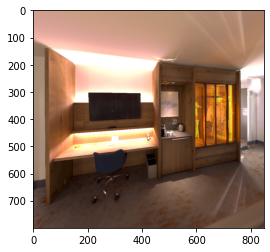

In [38]:
_show_image(right)

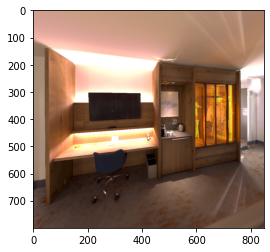

In [39]:
_show_image(right)

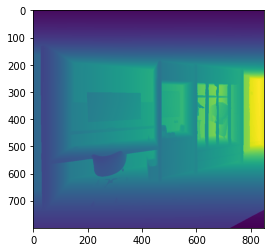

In [40]:
_show_image(depth)

In [41]:
depth.max(), depth.min()

(21451, 4783)

In [42]:
max_disp = 64
class Model(nn.Module):
    def setup(self):
        self.feature_extractor = features.GCNetFeature()
        self.cost_volume_construction = cost.CostVolume(max_disp=max_disp)
        self.aggregation = aggregate.DeformSimpleBottleneck(planes=max_disp // (2**0), num_deform_groups=1)
        self.disparity_computation = disparity.DisparityEstimation(max_disp=max_disp)
        self.disparity_refinment = refinement.StereoDRNetRefinement()
        
    @nn.compact
    def __call__(self, left_img, right_img):
        left_feature = self.feature_extractor(left_img)
        right_feature = self.feature_extractor(right_img)
        print("Feature shapes", left_feature.shape, right_feature.shape)
        
        cost_volume = self.cost_volume_construction(left_feature, right_feature)
        print("Cost volume", cost_volume.shape)
        
        aggregated = self.aggregation(cost_volume)
        print("Aggregated", aggregated.shape)
        
        disp = self.disparity_computation(cost_volume)
        print("Disparity", disp.shape)
        print(disp.max(), disp.min())
        
        refined = self.disparity_refinment(disp, left_img, right_img)
        print("Refined", refined.shape)      
        print(refined.max(), refined.min())
        
        return refined

In [43]:
model = Model() 
print("Original shapes", left.shape, right.shape)
_left = jax.image.resize(left, (400, 424, 3), method="bilinear")
_right = jax.image.resize(right, (400, 424, 3), method="bilinear")
_left = _left[jnp.newaxis, ...] / 255.
_right = _right[jnp.newaxis, ...] / 255.
variables = model.init(random.PRNGKey(0), _left, _right)

Original shapes (800, 848, 3) (800, 848, 3)
Feature shapes (1, 200, 212, 32) (1, 200, 212, 32)
Cost volume (1, 200, 212, 64)
Aggregated (1, 200, 212, 64)
Disparity (1, 200, 212)
62.957745 4.768631e-10
2.0
disp range 125.890625 6.0594175e-07
sample grid 1.0 -1.2886746
(1, 400, 424) (1, 400, 424)
result 0.8150561 0.4978291
result 0.8150561 0.4978291
result 0.8150561 0.4978291
result 0.8150561 0.4978291
56.395092 0.99764013 56.024223 0.9940311
out range 45.705196 -45.705196
(4, 1, 400, 424, 3)
(1, 400, 424, 3)
0.99999994 0.0
0.8148609 0.0
(1, 400, 424, 3)
error range <bound method amax of DeviceArray([[[[-0.82844913, -0.6292181 , -0.5589672 ],
               [-0.8296919 , -0.6272409 , -0.5687675 ],
               [-0.8287815 , -0.6259104 , -0.57093835],
               ...,
               [ 0.14237916,  0.14505488,  0.40568447],
               [ 0.1437797 ,  0.07845235,  0.4050542 ],
               [ 0.14250225,  0.01005763,  0.40638337]],

              [[-0.8254286 , -0.6300282 , -0.5644

In [44]:
@jax.jit
def apply(variables, left_img, right_img):
    y, modified_vars = model.apply(variables, left_img, right_img, mutable=['batch_stats'])
    return y

In [45]:
y = apply(variables, _left, _right)

Feature shapes (1, 200, 212, 32) (1, 200, 212, 32)
Cost volume (1, 200, 212, 64)
Aggregated (1, 200, 212, 64)
Disparity (1, 200, 212)
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
2.0
disp range Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
sample grid Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
(1, 400, 424) (1, 400, 424)
result Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
result Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
result Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
result Tra

In [46]:
y[0, 0, 10]

DeviceArray(3.5747023, dtype=float32)

In [47]:
depth.max(), depth.min()

(21451, 4783)

In [48]:
def _depth_to_disparity(depth):
    # Invert by the formula d = (b*f) / z
    b = 18.17
    f = 286.29
    
    _disparity = (b*f) / depth
    # Scale between [0, 1] then [0, 64]
    def _scale(x):
        return (x - x.min()) / (x.max() - x.min())
    disparity = _scale(_disparity) * 64.
    return disparity
    
_depth = jax.image.resize(depth, (400, 424), method="bilinear")
_depth = jnp.expand_dims(_depth, axis=0)
print(_depth.shape)
_disparity = _depth_to_disparity(_depth)

(1, 400, 424)


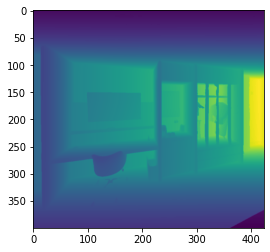

In [49]:
_show_image(_depth[0])

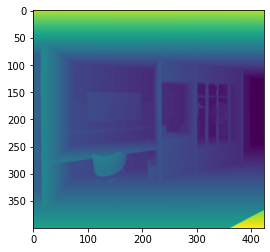

In [50]:
_show_image(_disparity[0])

In [51]:
_disparity.max(), _disparity.min()

(DeviceArray(64., dtype=float32), DeviceArray(0., dtype=float32))

In [52]:
@jax.jit
def create_optimizer(params, learning_rate=0.0001):
    optimizer_def = optim.Adam(learning_rate=learning_rate)
    optimizer = optimizer_def.create(params)
    return optimizer

@jax.jit
def disparity_loss(disp, gt_disp):
    gt_disp = jax.image.resize(gt_disp, disp.shape, method="bilinear")
    return jnp.sum(jnp.abs(disp - gt_disp))

@jax.jit
def train_step(optimizer, batch, error=disparity_loss):
    left_img = batch['left']
    right_img = batch['right']
    gt_disp = batch['disparity']

    def _loss(params):
        disp = apply(params, left_img, right_img)                                                                                                                                 
        return error(disp, gt_disp)

    grad_fn = jax.value_and_grad(_loss)
    loss, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer, loss

In [53]:
_batch = {
    'left': _left,
    'right': _right,
    'disparity': _disparity,
}

optimizer = create_optimizer(variables)

In [58]:
for i in range(1000000):
    optimizer, loss = train_step(optimizer, _batch)
    if i % 100 == 0:
        print(f"i = {i}, loss = {loss}")

i = 0, loss = 94165.921875
i = 100, loss = 99308.3125
i = 200, loss = 93694.2109375
i = 300, loss = 114189.390625
i = 400, loss = 91147.9765625
i = 500, loss = 98349.6796875
i = 600, loss = 93669.640625
i = 700, loss = 87138.9921875
i = 800, loss = 83387.6015625
i = 900, loss = 79013.609375
i = 1000, loss = 90987.9296875
i = 1100, loss = 84017.9765625
i = 1200, loss = 87140.6796875
i = 1300, loss = 81856.21875
i = 1400, loss = 72922.4296875
i = 1500, loss = 76310.09375
i = 1600, loss = 80067.9921875
i = 1700, loss = 77889.078125
i = 1800, loss = 84941.5625
i = 1900, loss = 62386.5546875
i = 2000, loss = 75847.2109375
i = 2100, loss = 67320.109375
i = 2200, loss = 71435.7734375
i = 2300, loss = 71314.0625
i = 2400, loss = 78932.3203125
i = 2500, loss = 63136.546875
i = 2600, loss = 70133.078125
i = 2700, loss = 61686.921875
i = 2800, loss = 74585.265625
i = 2900, loss = 62339.984375
i = 3000, loss = 71052.6171875
i = 3100, loss = 65165.35546875
i = 3200, loss = 82696.4375
i = 3300, loss

KeyboardInterrupt: 

In [61]:
disp = apply(optimizer.target, _left, _right)

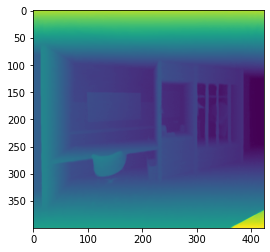

In [62]:
_show_image(disp[0])

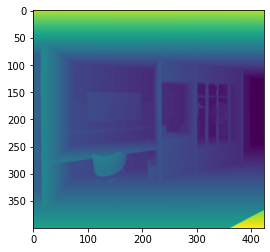

In [63]:
_show_image(_disparity[0])

In [66]:
jnp.mean(jnp.abs(disp - _disparity))

DeviceArray(0.16691135, dtype=float32)

In [69]:
disparity_loss(disp, _disparity)

DeviceArray(28308.168, dtype=float32)

In [72]:
400 * 424

169600